In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = r"C:\ZC\Data Governance\DataGovernanceWorkflow\data\ssh_logs_processed.csv"
df = pd.read_csv(file_path)

dataset_description = (
    "Dataset Description:\n"
    "This dataset contains SSH log data. Each record typically includes:\n"
    "- Date and Time when the log was recorded\n"
    "- IP address and Port used during the SSH connection attempt\n"
    "- Username and Password fields attempted\n"
    "- Country and City indicating the geographic origin\n"
    "It can be used to analyze security events and detect potential anomalies.\n"
)
print(dataset_description)

def profile_numeric(column_data: pd.Series) -> str:
    """Compute statistics for numeric columns."""
    min_val = column_data.min()
    max_val = column_data.max()
    mean_val = column_data.mean()
    # Sometimes mode returns multiple values; we'll choose the first one.
    mode_val = column_data.mode().iloc[0] if not column_data.mode().empty else np.nan
    data_type = str(column_data.dtype)
    null_count = column_data.isnull().sum()

    return (
        f"Min: {min_val}, Max: {max_val}, Mean: {mean_val:.2f}, "
        f"Mode: {mode_val}, Data type: {data_type}, Nulls: {null_count}"
    )

def profile_datetime(column_data: pd.Series) -> str:
    """Profile for datetime columns: earliest date, latest date, data type, and null count."""
    column_data = pd.to_datetime(column_data, errors='coerce')
    min_val = column_data.min()
    max_val = column_data.max()
    data_type = str(column_data.dtype)
    null_count = column_data.isnull().sum()
    return (
        f"Earliest: {min_val}, Latest: {max_val}, Data type: {data_type}, Nulls: {null_count}"
    )

def profile_categorical(column_data: pd.Series) -> str:
    """Profile for categorical/text columns: unique values list (or count), data type, and null count."""
    data_type = str(column_data.dtype)
    null_count = column_data.isnull().sum()
    unique_vals = column_data.dropna().unique()
    unique_sample = list(unique_vals[:5])
    return (
        f"Unique (sample): {unique_sample}, Data type: {data_type}, Nulls: {null_count}"
    )


Dataset Description:
This dataset contains SSH log data. Each record typically includes:
- Date and Time when the log was recorded
- IP address and Port used during the SSH connection attempt
- Username and Password fields attempted
- Country and City indicating the geographic origin
It can be used to analyze security events and detect potential anomalies.



In [42]:
print(df.columns)

Index(['Date', 'Time', 'IP', 'Port', 'Username', 'Password', 'Country',
       'City'],
      dtype='object')


In [43]:
rows = []
for col in df.columns:
    if col.lower() in ['port']:
        profiling_info = profile_numeric(df[col])
    elif col.lower() in ['date']:
        profiling_info = profile_datetime(df[col])
    else:
        profiling_info = profile_categorical(df[col])
    
    dependencies = "Manual analysis required"
    
    notes = ""
    if col.lower() == "date":
        notes = "May correlate with Time to show trends."
    elif col.lower() == "time":
        notes = "Check for peaks in activity based on time of day."
    elif col.lower() == "ip":
        notes = "Useful for geolocation and threat detection."
    elif col.lower() == "port":
        notes = "Identify commonly targeted ports (e.g., SSH on port 22)."
    elif col.lower() == "username":
        notes = "Analyze repeated login attempts for specific usernames."
    elif col.lower() == "password":
        notes = "Look for patterns in attempted passwords."
    elif col.lower() == "country":
        notes = "Can indicate regional trends."
    elif col.lower() == "city":
        notes = "Further granularity for geographic analysis."
    
    rows.append({
        "Column Name": col,
        "Profiling Info": profiling_info,
        "Dependencies": dependencies,
        "Notes": notes
    })
result_df = pd.DataFrame(rows)
styled_df = result_df.style.set_properties(**{
    'white-space': 'pre-wrap',
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index')
styled_df = styled_df.apply(lambda x: ['background-color: #f9f9f9' if x.name % 2 == 0 else '' for _ in x], axis=1)

styled_df

Column Name,Profiling Info,Dependencies,Notes
Date,"Earliest: 2024-07-17 00:00:00, Latest: 2024-09-16 00:00:00, Data type: datetime64[ns], Nulls: 0",Manual analysis required,May correlate with Time to show trends.
Time,"Unique (sample): ['20:22:06', '20:34:39', '20:34:43', '20:48:15', '20:48:21'], Data type: object, Nulls: 0",Manual analysis required,Check for peaks in activity based on time of day.
IP,"Unique (sample): ['85.209.11.227', '146.70.121.173', '181.176.161.157', '193.201.9.156', '183.81.169.238'], Data type: object, Nulls: 0",Manual analysis required,Useful for geolocation and threat detection.
Port,"Min: 1, Max: 65535, Mean: 43418.01, Mode: 41796, Data type: int64, Nulls: 0",Manual analysis required,"Identify commonly targeted ports (e.g., SSH on port 22)."
Username,"Unique (sample): ['admin', 'sshd', 'msf', 'bom', 'testuser1'], Data type: object, Nulls: 5",Manual analysis required,Analyze repeated login attempts for specific usernames.
Password,"Unique (sample): ['admin', '1', 'msf', 'bom', 'testuser1'], Data type: object, Nulls: 147",Manual analysis required,Look for patterns in attempted passwords.
Country,"Unique (sample): ['Russia', 'United Kingdom', 'Peru', 'The Netherlands', 'Sweden'], Data type: object, Nulls: 0",Manual analysis required,Can indicate regional trends.
City,"Unique (sample): ['Moscow', 'Stretford', 'Huaraz', 'Amsterdam', 'London'], Data type: object, Nulls: 0",Manual analysis required,Further granularity for geographic analysis.


In [44]:
print(df.columns)

Index(['Date', 'Time', 'IP', 'Port', 'Username', 'Password', 'Country',
       'City'],
      dtype='object')


In [45]:
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + " " + df['Time'], errors='coerce')

if df['Datetime'].isnull().sum() > 0:
    print("Warning: Some Date/Time conversions failed. Please verify the format in your CSV.")
df['Hour'] = df['Datetime'].dt.hour
hourly_counts = df.groupby('Hour').size().sort_index()
print("\nLogin attempts by hour:")
print(hourly_counts)


Login attempts by hour:
Hour
0     4528
1     3839
2     4919
3     6751
4     9245
5     7921
6     9449
7     7077
8     5576
9     4661
10    3860
11    3776
12    4379
13    3384
14    3165
15    3761
16    3342
17    2837
18    2424
19    2500
20    2074
21    2411
22    2552
23    4948
dtype: int64


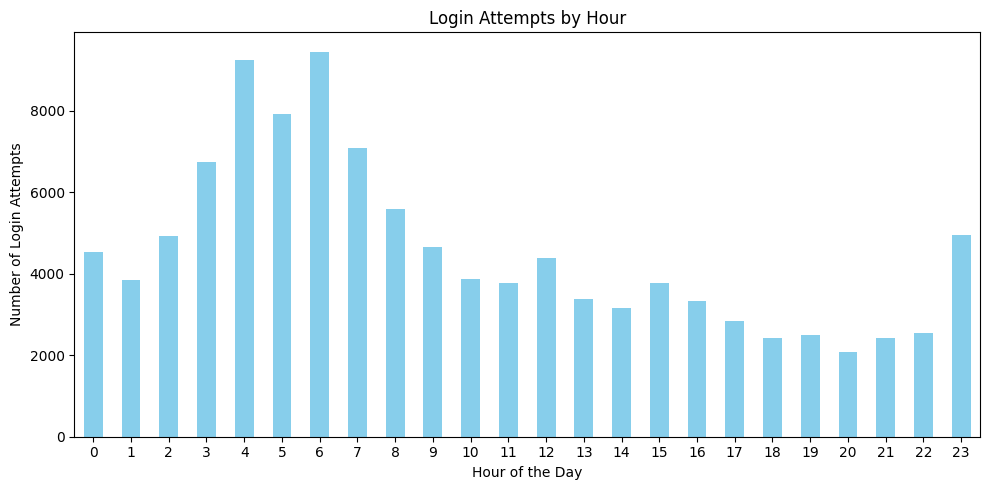

In [46]:
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title("Login Attempts by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Login Attempts")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [47]:
country_counts = df['Country'].value_counts()
print("\nLogin attempts by Country:")
print(country_counts)


Login attempts by Country:
Country
Australia          24859
United States      24235
Singapore          10703
China               7895
The Netherlands     5112
                   ...  
Nicaragua              1
Cambodia               1
Saudi Arabia           1
Philippines            1
Tajikistan             1
Name: count, Length: 100, dtype: int64


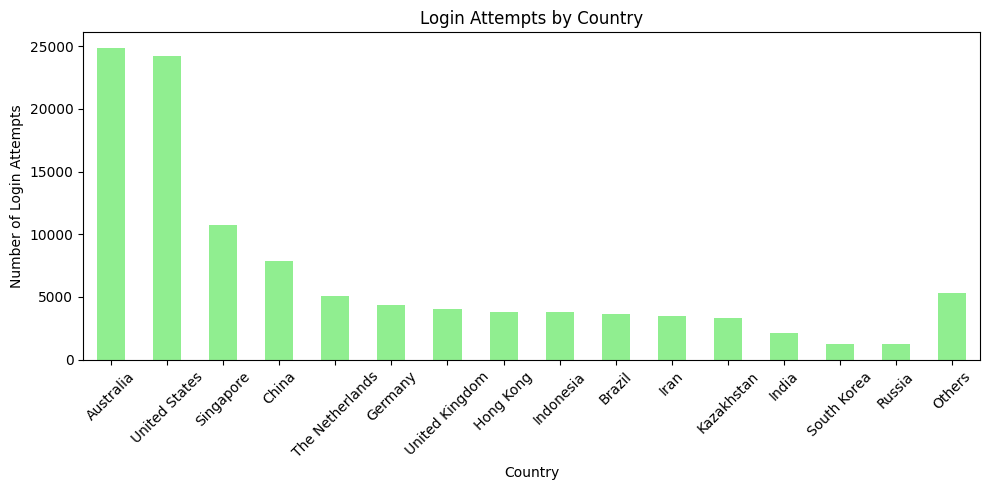

In [48]:
top_countries = country_counts.sort_values(ascending=False).head(15)
others_sum = country_counts.sum() - top_countries.sum()
country_counts_grouped = top_countries.copy()
if others_sum > 0:
    country_counts_grouped['Others'] = others_sum
plt.figure(figsize=(10, 5))
country_counts_grouped.plot(kind='bar', color='lightgreen')
plt.title("Login Attempts by Country")
plt.xlabel("Country")
plt.ylabel("Number of Login Attempts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
city_counts = df.groupby(['Country', 'City']).size().reset_index(name='Count')
print("\nLogin attempts by Country and City:")
print(city_counts.sort_values(by='Count', ascending=False))


Login attempts by Country and City:
             Country        City  Count
8          Australia      Sydney  22353
578    United States     Seattle  18177
351        Singapore   Singapore  10703
465  The Netherlands   Amsterdam   5107
490   United Kingdom      London   4014
..               ...         ...    ...
4          Australia    Adelaide      1
592    United States    Whittier      1
593    United States  Wilmington      1
594    United States      Woburn      1
595    United States      Yakima      1

[612 rows x 3 columns]
